In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable
from torch.utils.data import Dataset
from sklearn.metrics import classification_report
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import zipfile
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics.pairwise import euclidean_distances
import copy
import matplotlib.pyplot as plt

#function for loading the malaria dataset
def load_images_labels():
    archive_path = "/content/drive/MyDrive/ARU Final Project/Malaria Dataset/Malaria.zip"
    images = []
    labels = []
    classes = {'Parasitized': 0, 'Uninfected': 1}

    with zipfile.ZipFile(archive_path, 'r') as zip_ref:
        file_names = zip_ref.namelist()

        for class_name in classes:
            for file_name in file_names:
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')) and (class_name in os.path.dirname(file_name)):
                    with zip_ref.open(file_name) as file:
                        img_bytes = file.read()
                        nparr = np.frombuffer(img_bytes, np.uint8)
                        image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                        image = cv2.resize(image, (64, 64))
                        image = np.transpose(image, (2, 0, 1))
                        images.append(image)
                        labels.append(classes[class_name])
    return np.array(images), np.array(labels)


report1_data = []
topimages, toplabels = load_images_labels()
print("Total images in dataset: ",topimages.shape)
print("Total labels in dataset: ",toplabels.shape)

train_images, test_images, train_labels, test_labels = train_test_split(topimages, toplabels, test_size=0.30, random_state=42)
print("Train images in dataset: ",train_images.shape)
print("Train labels in dataset: ",train_labels.shape)
print("Test images in dataset : ",test_images.shape)
print("Test labels in dataset : ",test_labels.shape)

num_classes = 2 # Number of classes (Parasitized and Uninfected)


train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)


Total images in dataset:  (27558, 3, 64, 64)
Total labels in dataset:  (27558,)
Train images in dataset:  (19290, 3, 64, 64)
Train labels in dataset:  (19290,)
Test images in dataset :  (8268, 3, 64, 64)
Test labels in dataset :  (8268,)


In [ ]:
# First Component of Splitfed Model (Neural Network Model)

class NeuralNetworkModel(nn.Module):
    def __init__(self):
        super(NeuralNetworkModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes -> Parasitized and Uninfected

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
# Second Component of Splitfed Model (Splitfed Learner)

class SplitFedLearner:
    def __init__(self, model, num_clients, client_data, client_labels):
        self.model = model
        self.num_clients = num_clients
        self.client_data = client_data
        self.client_labels = client_labels

    def train(self, num_epochs, learning_rate):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)
        print("------------Model Training--------------------------")
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            correct = 0
            total = 0


            client_models = []  # List to store local models for each client
            client_accuracy = []
            for client_id in range(self.num_clients):
                client_data = self.client_data[client_id]
                client_labels = self.client_labels[client_id]
                correct_res = 0
                total_res = 0


                train_dataset = TensorDataset(torch.tensor(client_data).float(), torch.tensor(client_labels))
                train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

                client_model = NeuralNetworkModel()
                client_model.load_state_dict(self.model.state_dict())  # Initialize the local model with the global model's weights

                client_optimizer = optim.SGD(client_model.parameters(), lr=learning_rate)

                client_model.train()

                for inputs, labels in train_loader:
                    client_optimizer.zero_grad()
                    outputs = client_model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    client_optimizer.step()
                    epoch_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    labels = torch.argmax(labels, dim=1)  # Convert labels to 1D tensor
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    correct_res += (predicted == labels).sum().item()
                    total_res += labels.size(0)

                cl_arr = 100 * correct_res / total_res
                client_accuracy.append(cl_arr)
                client_models.append(client_model)  # Store the trained local model


            self.aggregate_models(client_models)  # Aggregate client model updates to the global model

            accuracy = 100 * correct / total
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}, Overall Accuracy: {accuracy:.2f}%")
            itr = 0
            #printing the accuracy of each client during epoch traning
            for i in client_accuracy:
              itr += 1
              print(f"Client:{itr}   Accuracy:{i:.2f}%  ||",end=" ")
            print("",end="\n")
        print("-----------------------Model Training end-----------------------------------------")



    def aggregate_models(self, client_models):
        # Aggregate client model updates to the global model
        global_state_dict = self.model.state_dict()
        for key in global_state_dict:
            global_state_dict[key] = torch.stack([client_models[i].state_dict()[key] for i in range(self.num_clients)]).mean(dim=0)
        self.model.load_state_dict(global_state_dict)

    def test(self, test_data, test_labels):
        self.model.eval()
        test_dataset = TensorDataset(torch.tensor(test_data).float(), torch.tensor(test_labels))
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        total = 0
        correct = 0
        predicted_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                predicted_labels.extend(predicted.tolist())
                labels = torch.argmax(labels, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            report1_data.append(accuracy)
            print(f"Test Accuracy: {accuracy:.2f}%")

            predicted_labels = np.array(predicted_labels)
            ground_truth_labels = np.argmax(test_labels, axis=1)

            report = classification_report(ground_truth_labels, predicted_labels)
            print(report)


In [ ]:
#Initialization of data for scenario 1
num_clients = 5  # Number of clients is 5
train_size = len(train_images) // num_clients

#Distribution of images and labels to the clients
client_data = [train_images[i:i + train_size] for i in range(0, train_size * num_clients, train_size)]
client_labels = [train_labels[i:i + train_size] for i in range(0, train_size * num_clients, train_size)]

In [ ]:
#Scenario 1: (Training and Testing splitfed model without malicious clients)

copy_client_data = copy.deepcopy(client_data)
copy_client_labels = copy.deepcopy(client_labels)

# Initialize the model and SplitFed learner
model = NeuralNetworkModel()
split_fed_learner = SplitFedLearner(model, num_clients, copy_client_data, copy_client_labels)

# Train the SplitFed learner
num_epochs = 100  #Number of epochs for training
learning_rate = 0.001
split_fed_learner.train(num_epochs, learning_rate)

# Test the model with test data
split_fed_learner.test(test_images, test_labels)

------------Model Training--------------------------
Epoch 1/100, Loss: 3730.141120195389, Overall Accuracy: 56.93%
Client:1   Accuracy:55.99%  || Client:2   Accuracy:57.28%  || Client:3   Accuracy:56.95%  || Client:4   Accuracy:57.83%  || Client:5   Accuracy:56.58%  || 
Epoch 2/100, Loss: 399.3185946941376, Overall Accuracy: 60.29%
Client:1   Accuracy:60.13%  || Client:2   Accuracy:60.37%  || Client:3   Accuracy:59.67%  || Client:4   Accuracy:60.86%  || Client:5   Accuracy:60.42%  || 
Epoch 3/100, Loss: 383.77431431412697, Overall Accuracy: 63.50%
Client:1   Accuracy:62.65%  || Client:2   Accuracy:63.48%  || Client:3   Accuracy:63.27%  || Client:4   Accuracy:64.15%  || Client:5   Accuracy:63.95%  || 
Epoch 4/100, Loss: 371.93869066238403, Overall Accuracy: 65.83%
Client:1   Accuracy:65.22%  || Client:2   Accuracy:66.07%  || Client:3   Accuracy:66.04%  || Client:4   Accuracy:65.99%  || Client:5   Accuracy:65.81%  || 
Epoch 5/100, Loss: 360.2855681478977, Overall Accuracy: 67.86%
Client

In [ ]:
def Euclidean_attack(c1_images,c2_images,c2_labels):

  c1_images_reshaped = c1_images.reshape(c1_images.shape[0], -1)
  c2_images_reshaped = c2_images.reshape(c2_images.shape[0], -1)

  distances = euclidean_distances(c1_images_reshaped, c2_images_reshaped)

  # Find the nearest neighbor for each instance
  nearest_neighbors = np.argmin(distances, axis=1)
  farthest_neighbors = np.argmax(distances, axis=1)
  print("nearest_neighbors---> ",nearest_neighbors)
  print("farthest_neighbors---> ",farthest_neighbors)

  # Perform the Euclidean distance attack by modifying the test instances to match their nearest neighbors
  modified_temp_images = c2_images[nearest_neighbors]
  modified_temp_labels = c2_labels[farthest_neighbors]

  return modified_temp_images,modified_temp_labels

In [ ]:
#Scenario 2: (Training and Testing splitfed model with malicious clients)
num_clients = 5
euc_atk_num = 2
copy_client_data = copy.deepcopy(client_data)
copy_client_labels = copy.deepcopy(client_labels)
comp_train_data = copy.deepcopy(client_data)
comp_train_label = copy.deepcopy(client_labels)
for i in range(0, len(client_data)):
    if(i < euc_atk_num):
      comp_train_data.pop(0)
      comp_train_label.pop(0)




for id in range(euc_atk_num):
  print("copy_client_data -->",len(copy_client_data))
  print("comp_train_data -->",len(comp_train_data))
  poisoned_client_image,poisoned_client_label = Euclidean_attack(copy_client_data[id],comp_train_data[id],comp_train_label[id])

  copy_client_data.append(poisoned_client_image)
  copy_client_labels.append(poisoned_client_label)
  num_clients = num_clients + 1





# Initialize the model and SplitFed learner
model1 = NeuralNetworkModel()
split_fed_learner1 = SplitFedLearner(model1, num_clients, copy_client_data, copy_client_labels)

# Train the SplitFed learner
num_epochs = 100
learning_rate = 0.001
split_fed_learner1.train(num_epochs, learning_rate)

# Test the model with test data
split_fed_learner1.test(test_images, test_labels)


copy_client_data --> 5
comp_train_data --> 3
nearest_neighbors--->  [2894 3229 2630 ... 1836 1241 3060]
farthest_neighbors--->  [3427 3427 3427 ... 3367 3427 2533]
copy_client_data --> 6
comp_train_data --> 3
nearest_neighbors--->  [1488 2328 2925 ... 1885 1362 2043]
farthest_neighbors--->  [3732 2160 2160 ... 3732 2160 2160]
------------Model Training--------------------------
Epoch 1/100, Loss: 19504.72924446687, Overall Accuracy: 64.14%
Client:1   Accuracy:55.13%  || Client:2   Accuracy:56.51%  || Client:3   Accuracy:56.48%  || Client:4   Accuracy:56.14%  || Client:5   Accuracy:55.52%  || Client:6   Accuracy:93.57%  || Client:7   Accuracy:75.61%  || 
Epoch 2/100, Loss: 485.1234093066305, Overall Accuracy: 66.21%
Client:1   Accuracy:58.09%  || Client:2   Accuracy:58.22%  || Client:3   Accuracy:59.36%  || Client:4   Accuracy:58.45%  || Client:5   Accuracy:59.10%  || Client:6   Accuracy:94.66%  || Client:7   Accuracy:75.61%  || 
Epoch 3/100, Loss: 468.5859318803996, Overall Accuracy: 6

In [ ]:


class SecureSplitFedLearner:
    def __init__(self, model, num_clients, client_data, client_labels):
        self.model = model
        self.num_clients = num_clients
        self.client_data = client_data
        self.client_labels = client_labels
        self.epoch_acc = []




    def train(self, num_epochs, learning_rate):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)
        print("------------Model Training--------------------------")
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            correct = 0
            total = 0

            client_models = []  # List to store local models for each client
            client_accuracy = []
            for client_id in range(self.num_clients):
                correct_res = 0
                total_res = 0
                client_data = self.client_data[client_id]
                client_labels = self.client_labels[client_id]


                train_dataset = TensorDataset(torch.tensor(client_data).float(), torch.tensor(client_labels))
                train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

                client_model = NeuralNetworkModel()
                client_model.load_state_dict(self.model.state_dict())  # Initialize the local model with the global model's weights

                client_optimizer = optim.SGD(client_model.parameters(), lr=learning_rate)

                client_model.train()

                for inputs, labels in train_loader:
                    client_optimizer.zero_grad()
                    outputs = client_model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    client_optimizer.step()
                    epoch_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    labels = torch.argmax(labels, dim=1)  # Convert labels to 1D tensor
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    correct_res += (predicted == labels).sum().item()
                    total_res += labels.size(0)

                if(epoch == 0):
                    temp_arrlist = []

                    temp_arrlist.append(client_id)
                    accuracy_res = 100 * correct_res / total_res
                    arr = []
                    arr.append(accuracy_res)
                    temp_arrlist.append(arr)
                    self.epoch_acc.append(temp_arrlist)

                client_models.append(client_model)  # Store the trained local model in a list
                cl_arr = 100 * correct_res / total_res
                client_accuracy.append(cl_arr)

            if(epoch == 0):

              poisonedModel = self.findPoisonedClient(self.epoch_acc)
              #print("poisonedModel --->",poisonedModel)
              client_models = self.remove_model(client_models,poisonedModel)

            # Aggregate client model updates to the global model
            self.aggregate_models(client_models)


            accuracy = 100 * correct / total
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {accuracy:.2f}%")
            itr = 0
            #printing the accuracy of each client during epoch traning
            for i in client_accuracy:
              itr += 1
              print(f"Client:{itr}   Accuracy:{i:.2f}%  ||",end=" ")
            print("",end="\n")
        print("-----------------------Model Training end1-----------------------------------------")

    def findPoisonedClient(self,epoch_acc_arr):
      sum = 0
      suspect = []
      num_range = [0,0,0,0,0,0,0,0,0,0,0]


      for i in epoch_acc_arr:
        if(i[1][0] <= 10):
          num_range[0] = num_range[0] + 1
        elif(i[1][0] <= 20):
          num_range[1] = num_range[1] + 1
        elif(i[1][0] <= 30):
          num_range[2] = num_range[2] + 1
        elif(i[1][0] <= 40):
          num_range[3] = num_range[3] + 1
        elif(i[1][0] <= 50):
          num_range[4] = num_range[4] + 1
        elif(i[1][0] <= 60):
          num_range[5] = num_range[5] + 1
        elif(i[1][0] <= 70):
          num_range[6] = num_range[6] + 1
        elif(i[1][0] <= 80):
          num_range[7] = num_range[7] + 1
        elif(i[1][0] <= 90):
          num_range[8] = num_range[8] + 1
        elif(i[1][0] <= 100):
          num_range[9] = num_range[9] + 1

        max_value = max(num_range)
        max_index = num_range.index(max_value)

        lower_lim = max_index * 10
        upper_lim = (max_index + 1) * 10

      for i in epoch_acc_arr:
        if(i[1][0] > lower_lim and i[1][0] <= upper_lim):
          sum = sum + i[1][0]

        #calculate mean
      mean = sum/max_value

      print("Mean is :", mean)

        #find the average squared difference of the value and mean
      for i in epoch_acc_arr:
        diff = (i[1][0]-mean)**2
        print(diff)

        if diff>100:
          suspect.append(i)


      print(suspect)
      return suspect

    def remove_model(self, clientmodel,poison_models):
        #[[0, [69.85711045588569]], [1, [71.26332501701066]]]
        print("poison_models --->",poison_models)
        for i in reversed(poison_models):
          clientmodel.pop(i[0])
          self.num_clients = self.num_clients - 1
          self.client_data.pop(i[0])
          self.client_labels.pop(i[0])

          print("removed-->", i)
        return clientmodel




    def aggregate_models(self, client_models):
        # Aggregate client model updates to the global model
        global_state_dict = self.model.state_dict()
        for key in global_state_dict:
            global_state_dict[key] = torch.stack([client_models[i].state_dict()[key] for i in range(self.num_clients)]).mean(dim=0)
        self.model.load_state_dict(global_state_dict)

    def test(self, test_data, test_labels):
        self.model.eval()
        test_dataset = TensorDataset(torch.tensor(test_data).float(), torch.tensor(test_labels))
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        total = 0
        correct = 0
        predicted_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                predicted_labels.extend(predicted.tolist())
                labels = torch.argmax(labels, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            report1_data.append(accuracy)
            print(f"Test Accuracy: {accuracy:.2f}%")
            predicted_labels = np.array(predicted_labels)
            ground_truth_labels = np.argmax(test_labels, axis=1)

            report = classification_report(ground_truth_labels, predicted_labels)
            print(report)


In [ ]:

num_clients = 7
# Initialize the model and SplitFed learner
model2 = NeuralNetworkModel()
print("copy_client_data -->",len(copy_client_data))
print("copy_client_data -->",len(copy_client_labels))
sec_split_fed_learner = SecureSplitFedLearner(model2, num_clients, copy_client_data, copy_client_labels)

# Train the SplitFed learner
num_epochs = 100
learning_rate = 0.001
sec_split_fed_learner.train(num_epochs, learning_rate)

# Test the model with test data
sec_split_fed_learner.test(test_images, test_labels)

copy_client_data --> 7
copy_client_data --> 7
------------Model Training--------------------------
Mean is : 55.70243649559357
0.5267343197777108
0.006046694997449434
0.32517781986277683
0.32517781986277683
0.24253965489764265
1292.4938209495683
267.5064585421126
[[5, [91.65370658372214]], [6, [72.0580611715915]]]
poison_models ---> [[5, [91.65370658372214]], [6, [72.0580611715915]]]
removed--> [6, [72.0580611715915]]
removed--> [5, [91.65370658372214]]
Epoch 1/100, Loss: 13676.803224455565, Accuracy: 63.17%
Client:1   Accuracy:54.98%  || Client:2   Accuracy:55.78%  || Client:3   Accuracy:56.27%  || Client:4   Accuracy:56.27%  || Client:5   Accuracy:55.21%  || Client:6   Accuracy:91.65%  || Client:7   Accuracy:72.06%  || 
Epoch 2/100, Loss: 400.17618584632874, Accuracy: 60.37%
Client:1   Accuracy:59.80%  || Client:2   Accuracy:60.81%  || Client:3   Accuracy:61.02%  || Client:4   Accuracy:59.77%  || Client:5   Accuracy:60.45%  || 
Epoch 3/100, Loss: 385.2546897828579, Accuracy: 63.76%
C

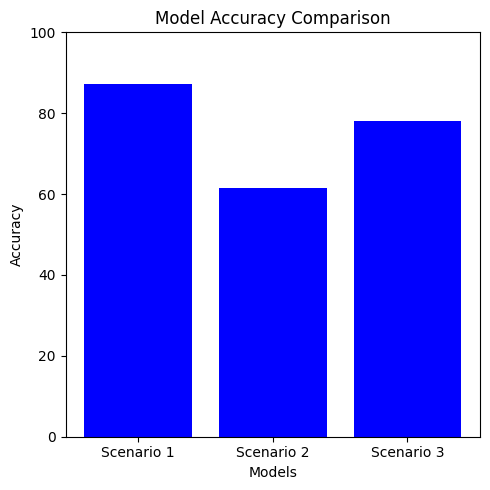

In [ ]:
def plot_accuracy_comparison(model_names, accuracies):
    plt.figure(figsize=(5, 5))
    plt.bar(model_names, accuracies, color='blue')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

model_names = ['Scenario 1', 'Scenario 2', 'Scenario 3']
plot_accuracy_comparison(model_names, report1_data)

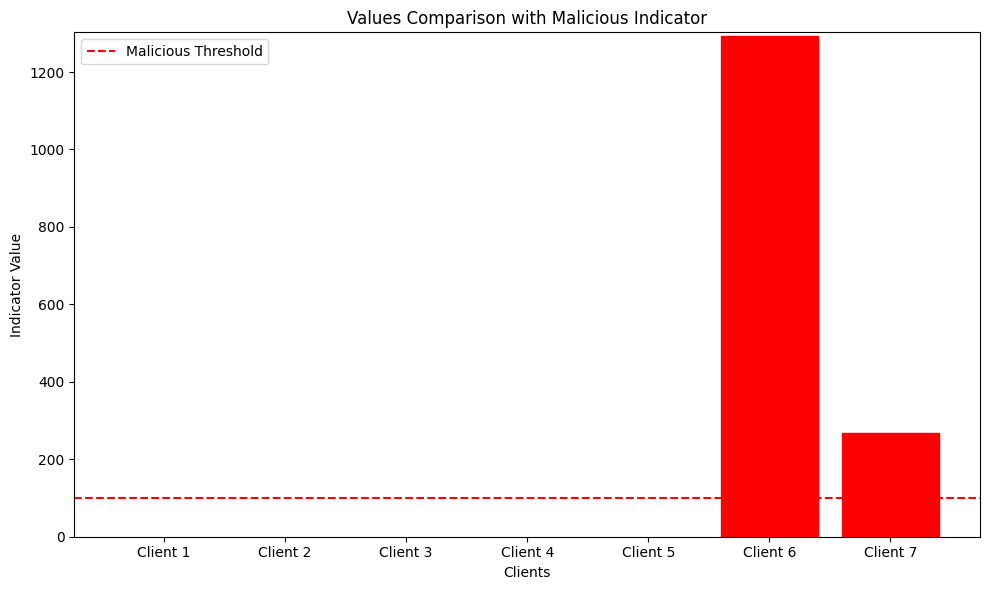

In [ ]:

def plot_malicious_threshold_graph(values):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(values)), values, color='green')

    # Highlight malicious values with a different color
    for i, value in enumerate(values):
        if value > 100:
            bars[i].set_color('red')

    plt.axhline(y=100, color='red', linestyle='--', label='Malicious Threshold')

    plt.xlabel('Clients')
    plt.ylabel('Indicator Value')
    plt.title('Values Comparison with Malicious Indicator')
    plt.ylim(0, max(values) + 10)



    plt.xticks(range(len(values)), ["Client "+str(i+1) for i in range(len(values))])
    plt.legend()
    plt.tight_layout()
    plt.show()


sqt_diff = [0.5267343197777108,0.32517781986277683,0.006046694997449434,0.32517781986277683,0.24253965489764265,1292.4938209495683,267.5064585421126]
malicious_threshold = 100

plot_malicious_threshold_graph(sqt_diff)
